[Table of Contents](./table_of_contents.ipynb)

# Вероятности, теорема Гаусса и Байеса

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Вступление

Последняя глава завершилась обсуждением некоторых недостатков дискретного байесовского фильтра. Для многих задач отслеживания и фильтрации мы хотим иметь фильтр, который является *унимодальным* и *непрерывным*. То есть мы хотим смоделировать нашу систему с использованием математики с плавающей запятой (непрерывной) и представить только одно убеждение (унимодальное). Например, мы хотим сказать, что самолет находится в (12.34, -95.54, 2389.5), где это широта, долгота и высота. Мы не хотим, чтобы наш фильтр сообщал нам: "это может быть (1.65, -78.01, 2100.45) или это может быть (34.36, -98.23, 2543.79)". Это не соответствует нашей физической интуиции о том, как устроен мир, и, как мы уже обсуждали, вычисление мультимодального случая может быть непомерно дорогостоящим. И, конечно же, множественные оценки местоположения делают навигацию невозможной.

Нам нужен унимодальный, непрерывный способ представления вероятностей, который моделирует, как работает реальный мир, и который эффективен с точки зрения вычислений. Гауссовы распределения обеспечивают все эти функции.

## Среднее значение, Дисперсия и стандартные отклонения

Большинство из вас, вероятно, имели дело со статистикой, но позвольте мне в любом случае осветить этот материал. Я прошу вас прочитать материал, даже если вы уверены, что хорошо его знаете. Я спрашиваю по двум причинам. Во-первых, я хочу быть уверен, что мы используем термины одинаково. Во-вторых, я стремлюсь сформировать интуитивное понимание статистики, которое сослужит вам хорошую службу в последующих главах. Легко пройти курс статистики и запомнить только формулы и вычисления и, возможно, быть нечетким в отношении последствий того, что вы узнали.

### Случайные Величины

Каждый раз, когда вы бросаете кубик, *результат* будет составлять от 1 до 6. Если бы мы бросили честный кубик миллион раз, мы бы ожидали получить один в 1/6 случаев. Таким образом, мы говорим, что *вероятность* или *шансы* исхода 1 равны 1/6. Аналогично, если бы я спросил вас, какова вероятность того, что 1 будет результатом следующего броска, вы бы ответили 1/6.

Эта комбинация значений и связанных с ними вероятностей называется [*случайной величиной*](https://en.wikipedia.org/wiki/Random_variable ). Здесь *случайный* не означает, что процесс недетерминирован, только то, что нам не хватает информации о результате. Результат броска кубика детерминирован, но нам не хватает информации для вычисления результата. Мы не знаем, что произойдет, кроме как вероятностно.

Пока мы определяем термины, диапазон значений называется [*пространство выборки*](https://en.wikipedia.org/wiki/Sample_space ). Для матрицы пространство выборки равно {1, 2, 3, 4, 5, 6}. Для монеты пространство выборки равно {H, T}. *Пространство* - это математический термин, который означает множество со структурой. Пространство выборки для кубика представляет собой подмножество натуральных чисел в диапазоне от 1 до 6.

Другим примером случайной величины является рост студентов в университете. Здесь пространство выборки представляет собой диапазон значений в действительных числах между двумя пределами, определенными биологией.

Случайные величины, такие как броски монет и броски кубиков, являются *дискретными случайными величинами*. Это означает, что их выборочное пространство представлено либо конечным числом значений, либо счетно бесконечным числом значений, таких как натуральные числа. Высоты людей называются *непрерывными случайными величинами*, поскольку они могут принимать любое реальное значение между двумя пределами.

Не путайте *измерение* случайной величины с фактическим значением. Если бы мы могли измерить рост человека только с точностью до 0,1 метра, мы бы записали только значения от 0,1, 0,2, 0,3 ... 2,7, что дало бы 27 дискретных вариантов. Тем не менее, рост человека может варьироваться в пределах любого произвольного реального значения между этими диапазонами, и поэтому рост является непрерывной случайной величиной. 

В статистике заглавные буквы используются для обозначения случайных величин, обычно из второй половины алфавита. Итак, мы могли бы сказать, что $X$ - это случайная величина, представляющая бросок кубика, или $Y$ - это рост студентов в классе поэзии первокурсников. В последующих главах для решения этих задач используется линейная алгебра, и поэтому здесь мы будем следовать соглашению об использовании нижнего регистра для векторов и верхнего регистра для матриц. К сожалению, эти соглашения вступают в противоречие, и вам придется определить, что автор использует из контекста. Я всегда использую жирные символы для векторов и матриц, что помогает различать их.

## Распределение вероятностей


[*Распределение вероятностей*](https://en.wikipedia.org/wiki/Probability_distribution) дает вероятность того, что случайная величина примет любое значение в пространстве выборки. Например, для простого шестигранного кубика мы могли бы сказать:

|Значение|Вероятность|
|-----|-----------|
|1|1/6|
|2|1/6|
|3|1/6|
|4|1/6|
|5|1/6|
|6|1/6|

Мы обозначим это распределение строчной буквой p: $p(x)$. Используя обычную нотацию функций, мы бы написали:

$$P(X{=}4) = p(4) = \frac{1}{6}$$

Это означает, что вероятность того, что кубик упадет на 4, равна $\frac {1} {6} $. $P (X {=} x_k) $ - это обозначение для "вероятности того, что $ X$ будет равен $x_k $". Обратите внимание на тонкую разницу в обозначениях. Заглавная буква $P$ обозначает вероятность одного события, а строчная буква $p$ - это функция распределения вероятностей. Это может ввести вас в заблуждение, если вы не будете наблюдательны. В некоторых текстах используется $ Pr $ вместо $ P $, чтобы улучшить это.

Другой пример - честная монета. Он имеет пространство выборки {H, T}. Монета честная, поэтому вероятность выпадения орла (H) составляет 50%, а вероятность выпадения решки (T) - 50%. Мы записываем это как

$$\begin{gathered}P(X{=}H) = 0.5\\P(X{=}T)=0.5\end{gathered}$$

Пробные пространства не являются уникальными. Одно пространство для выборки для матрицы составляет {1, 2, 3, 4, 5, 6}. Другим допустимым пространством выборки было бы {четное, нечетное}. Другим может быть {точки во всех углах, а не точки во всех углах}. Пространство выборки допустимо до тех пор, пока оно охватывает все возможности, и любое отдельное событие описывается только одним элементом.  {четный, 1, 3, 4, 5} не является допустимым пространством выборки для кубика, поскольку значение 4 соответствует как "четному", так и "4".

Вероятности для всех значений *дискретной случайной величины* известны как *дискретное распределение вероятностей*, а вероятности для всех значений *непрерывной случайной величины* известны как *непрерывное распределение вероятностей*.

Чтобы быть распределением вероятностей, вероятность каждого значения $x_i$ должна быть $x_i \ge 0$, поскольку никакая вероятность не может быть меньше нуля. Во-вторых, сумма вероятностей для всех значений должна быть равна единице. Это должно быть интуитивно понятно для подбрасывания монеты: если шансы получить орел составляют 70%, то шансы получить решку должны составлять 30%. Мы формализуем это требование следующим образом

$$\sum\limits_u P(X{=}u)= 1$$

для дискретных распределений 

$$\int\limits_u P(X{=}u) \,du= 1$$

для непрерывных распределений.

В предыдущей главе мы использовали распределения вероятностей для оценки положения собаки в коридоре. Например:

sum =  1.0


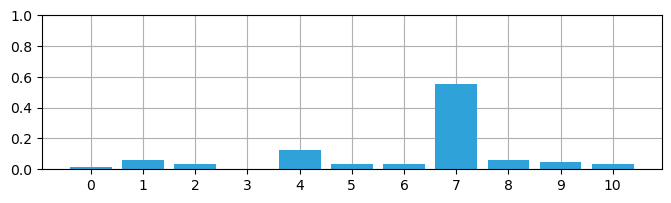

In [3]:
import numpy as np
import kf_book.book_plots as book_plots

belief = np.array([1, 4, 2, 0, 8, 2, 2, 35, 4, 3, 2])
belief = belief / np.sum(belief)
with book_plots.figsize(y=2):
    book_plots.bar_plot(belief)
print('sum = ', np.sum(belief))

Каждая позиция имеет вероятность от 0 до 1, а сумма всех равна единице, так что это делает ее распределением вероятностей. Каждая вероятность дискретна, поэтому мы можем точнее назвать это дискретным распределением вероятностей. На практике мы опускаем термины дискретный и непрерывный, если только у нас нет особой причины проводить это различие.

### Среднее значение, Медиана и Режим случайной величины

Учитывая набор данных, мы часто хотим знать репрезентативное или среднее значение для этого набора. Для этого существует множество мер, и эта концепция называется [*мерой центральной тенденции*](https://en.wikipedia.org/wiki/Central_tendency ). Например, мы могли бы захотеть узнать *средний* рост учащихся в классе. Мы все знаем, как найти среднее значение набора данных, но позвольте мне пояснить суть, чтобы я мог ввести более формальные обозначения и терминологию. Другое слово для обозначения среднего - "среднее". Мы вычисляем среднее значение путем суммирования значений и деления на количество значений. Если рост учащихся в метрах равен 

$$X = \{1.8, 2.0, 1.7, 1.9, 1.6\}$$

мы вычисляем среднее значение как

$$\mu = \frac{1.8 + 2.0 + 1.7 + 1.9 + 1.6}{5} = 1.8$$

Традиционно для обозначения среднего значения используется символ $\mu$ (мю).

Мы можем формализовать это вычисление с помощью уравнения

$$ \mu = \frac{1}{n}\sum^n_{i=1} x_i$$

NumPy предоставляет `numpy.mean()` для вычисления среднего значения.

In [4]:
x = [1.8, 2.0, 1.7, 1.9, 1.6]
np.mean(x)

1.8

Для удобства массивы NumPy предоставляют метод `mean()`.

In [6]:
x = np.array([1.8, 2.0, 1.7, 1.9, 1.6])
x.mean()

1.8

The *mode* of a set of numbers is the number that occurs most often. If only one number occurs most often we say it is a *unimodal* set, and if two or more numbers occur the most with equal frequency than the set is *multimodal*. For example the set {1, 2, 2, 2, 3, 4, 4, 4} has modes 2 and 4, which is multimodal, and the set {5, 7, 7, 13} has the mode 7, and so it is unimodal. We will not be computing the mode in this manner in this book, but we do use the concepts of unimodal and multimodal in a more general sense. For example, in the **Discrete Bayes** chapter we talked about our belief in the dog's position as a *multimodal distribution* because we assigned different probabilities to different positions.

Finally, the *median* of a set of numbers is the middle point of the set so that half the values are below the median and half are above the median. Here, above and below is in relation to the set being sorted.  If the set contains an even number of values then the two middle numbers are averaged together.

Numpy provides `numpy.median()` to compute the median. As you can see the median of {1.8, 2.0, 1.7, 1.9, 1.6} is 1.8, because 1.8 is the third element of this set after being sorted. In this case the median equals the mean, but that is not generally true.

In [6]:
np.median(x)

1.8

## Ожидаемое значение случайной величины

[*Ожидаемое значение*](https://en.wikipedia.org/wiki/Expected_value) случайной величины - это среднее значение, которое она имела бы, если бы мы взяли бесконечное число ее выборок, а затем усреднили эти выборки вместе. Допустим, у нас есть $ x = [1,3,5] $, и каждое значение одинаково вероятно. Какое значение мы *ожидаем* от $x$ в среднем?

Конечно, это было бы среднее значение 1, 3 и 5, что равно 3. Это должно иметь смысл; мы ожидаем, что будут встречаться равные числа 1, 3 и 5, так что $(1+3+5)/3=3$ очевидно, что это среднее значение этого бесконечная серия выборок. Другими словами, здесь ожидаемое значение - это *среднее значение* выборочного пространства.

Теперь предположим, что каждое значение имеет разную вероятность возникновения. Скажем, 1 имеет 80%-ную вероятность возникновения, 3 имеет 15%-ную вероятность, а 5 имеет только 5%-ную вероятность. В этом случае мы вычисляем ожидаемое значение путем умножения каждого значения $x$ на процентную вероятность его возникновения и суммирования результата. Для этого случая мы могли бы вычислить

$$\mathbb E[X] = (1)(0.8) + (3)(0.15) + (5)(0.05) = 1.5$$

Здесь я ввел обозначение $\mathbb E[X]$ для ожидаемого значения $x$. В некоторых текстах используется $E(x)$. Значение 1.5 для $x$ имеет интуитивный смысл, потому что $x$ с гораздо большей вероятностью будет равно 1, чем 3 или 5, а также 3 с большей вероятностью, чем 5.

Мы можем формализовать это, позволив $x_i$ быть $i ^ {th}$ значением $X$, а $p_i$ - вероятностью его возникновения. Это дает нам

$$\mathbb E[X] = \sum_{i=1}^n p_ix_i$$

Тривиальный кусочек алгебры показывает, что если все вероятности равны, то ожидаемое значение совпадает со средним:

$$\mathbb E[X] = \sum_{i=1}^n p_ix_i = \frac{1}{n}\sum_{i=1}^n x_i = \mu_x$$

Если $x$ непрерывен, мы подставляем сумму вместо интеграла, например

$$\mathbb E[X] = \int_{a}^b\, xf(x) \,dx$$

где $f(x)$ - функция распределения вероятностей для $x$. Мы пока не будем использовать это уравнение, но будем использовать его в следующей главе.

Мы можем написать немного Python, чтобы имитировать это. Здесь я беру 1 000 000 выборок и вычисляю ожидаемое значение распределения, которое мы только что вычислили аналитически.

In [7]:
total = 0
N = 1000000
for r in np.random.rand(N):
    if r <= .80: total += 1
    elif r < .95: total += 3
    else: total += 5

total / N

1.498882

Вы можете видеть, что вычисленное значение близко к аналитически полученному значению. Это не точно, потому что для получения точных значений требуется бесконечный размер выборки.

### Упражнение

Каково ожидаемое значение броска кубика?

### Решение

Каждая сторона одинаково вероятна, поэтому вероятность каждой из них равна 1/6. Следовательно
$$\begin{aligned}
\mathbb E[X] &= 1/6\times1 + 1/6\times 2 + 1/6\times 3 + 1/6\times 4 + 1/6\times 5 + 1/6\times6 \\
&= 1/6(1+2+3+4+5+6)\\&= 3.5\end{aligned}$$

### Упражнение

Учитывая равномерное непрерывное распределение

$$f(x) = \frac{1}{b - a}$$

вычислите ожидаемое значение для $a=0$ и $b=20$.

### Решение
$$\begin{aligned}
\mathbb E[X] &= \int_0^{20}\, x\frac{1}{20} \,dx \\
&= \bigg[\frac{x^2}{40}\bigg]_0^{20} \\
&= 10 - 0 \\
&= 10
\end{aligned}$$

### Дисперсия случайной величины

Приведенное выше вычисление показывает нам средний рост студентов, но оно не говорит нам всего, что мы, возможно, хотели бы знать. Например, предположим, что у нас есть три класса учащихся, которые мы обозначаем $X$, $Y$ и $Z$ следующими высотами:

In [8]:
X = [1.8, 2.0, 1.7, 1.9, 1.6]
Y = [2.2, 1.5, 2.3, 1.7, 1.3]
Z = [1.8, 1.8, 1.8, 1.8, 1.8]

Используя NumPy, мы видим, что средняя высота каждого класса одинакова.

In [9]:
print(np.mean(X), np.mean(Y), np.mean(Z))

1.8 1.8 1.8


Среднее значение для каждого класса составляет 1,8 метра, но обратите внимание, что во втором классе разница в высоте гораздо больше, чем в первом классе, а в третьем классе вообще нет различий.

Среднее значение говорит нам кое-что о данных, но не всю историю. Мы хотим иметь возможность указать, насколько велика *разница* между ростом учащихся. Вы можете представить себе целый ряд причин для этого. Возможно, школьному округу необходимо заказать 5000 парт, и они хотят быть уверены, что покупают размеры, соответствующие диапазону роста учащихся. 

Статистика формализовала эту концепцию измерения вариаций в понятие [*стандартное отклонение*](https://en.wikipedia.org/wiki/Standard_deviation) и [*дисперсии*](https://en.wikipedia.org/wiki/Variance). Уравнение для вычисления дисперсии имеет вид

$$\mathit{VAR}(X) = \mathbb  E[(X - \mu)^2]$$

Игнорируя квадрат на мгновение, вы можете видеть, что дисперсия - это *ожидаемое значение* для того, насколько пространство выборки $ X $ отличается от среднего $ \ mu: $ ($X-\ mu) $. Я объясню назначение квадратного члена позже. Формула для ожидаемого значения равна $ \mathbb E[X] = \sum \limits_{i= 1} ^ n p_ix_i $, поэтому мы можем подставить это в приведенное выше уравнение, чтобы получить

$$\mathit{VAR}(X) = \frac{1}{n}\sum_{i=1}^n (x_i - \mu)^2$$
 
Давайте вычислим дисперсию трех классов, чтобы увидеть, какие значения мы получаем, и ознакомиться с этой концепцией.

Среднее значение $X$ равно 1,8 ($\mu_x = 1,8$), поэтому мы вычисляем

$$ 
\begin{aligned}
\mathit{VAR}(X) &=\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5} \\
&= \frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5} \\
\mathit{VAR}(X)&= 0.02 \, m^2
\end{aligned}$$

NumPy предоставляет функцию `var()` для вычисления дисперсии:

In [11]:
print(f"{np.var(X):.2f} метров квадратных")

0.02 метров квадратных


Возможно, это немного сложно интерпретировать. Высоты указаны в метрах, но разница составляет метры в квадрате. Таким образом, у нас есть более часто используемая мера, *стандартное отклонение*, которое определяется как квадратный корень из дисперсии:

$$\sigma = \sqrt{\mathit{VAR}(X)}=\sqrt{\frac{1}{n}\sum_{i=1}^n(x_i - \mu)^2}$$

Обычно используется $\sigma$ для *стандартного отклонения* и $\sigma ^ 2 $ для *дисперсии*. В большей части этой книги я буду использовать $\sigma ^ 2$ вместо $\mathit{VAR}(X)$ для дисперсии; они символизируют одно и то же.

Для первого класса мы вычисляем стандартное отклонение с помощью

$$ 
\begin{aligned}
\sigma_x &=\sqrt{\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5}} \\
&= \sqrt{\frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5}} \\
\sigma_x&= 0.1414
\end{aligned}$$

Мы можем проверить это вычисление с помощью метода NumPy `numpy.std()`, который вычисляет стандартное отклонение. "std" - это распространенная аббревиатура стандартного отклонения.

In [14]:
print(f"std {np.std(X):.4f}")
print(f"var {np.std(X)**2:.4f}")

std 0.1414
var 0.0200


И, конечно же, $0,1414 ^ 2 = 0,02$, что согласуется с нашим более ранним вычислением дисперсии.

Что означает стандартное отклонение? Это говорит нам о том, насколько сильно различаются высоты между собой. "Сколько" - это не математический термин. Мы сможем определить его гораздо точнее, как только введем понятие гауссова в следующем разделе. А пока я скажу, что для многих вещей 68% всех значений лежат в пределах одного стандартного отклонения от среднего. Другими словами, мы можем сделать вывод, что для случайного класса 68% учащихся будут иметь высоту от 1,66 (1,8-0,1414) метра до 1,94 (1,8+ 0,1414) метра. 

Мы можем просмотреть это на графике:

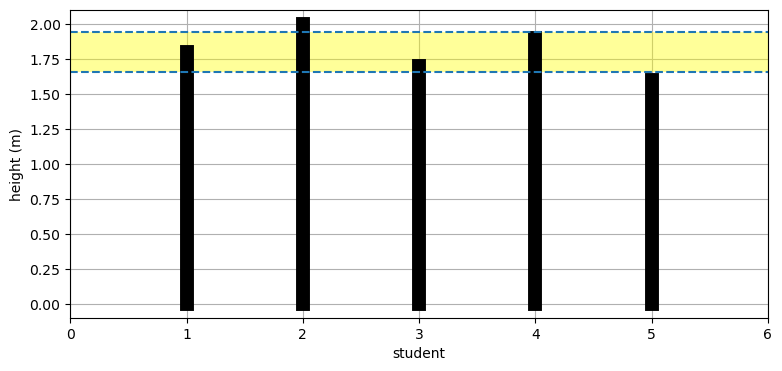

In [15]:
from kf_book.gaussian_internal import plot_height_std
import matplotlib.pyplot as plt

plot_height_std(X)

Очевидно, что только для 5 студентов мы не получим ровно 68% в пределах одного стандартного отклонения. Мы видим, что 3 из 5 студентов находятся в пределах $\pm1\sigma$, или 60%, что настолько близко, насколько вы можете приблизиться к 68% только с 5 выборками. Давайте посмотрим на результаты для класса со 100 учениками.

> Мы записываем одно стандартное отклонение как $1\sigma$, что произносится как "одно стандартное отклонение", а не "одна сигма". Два стандартных отклонения составляют $2\sigma$ и так далее.

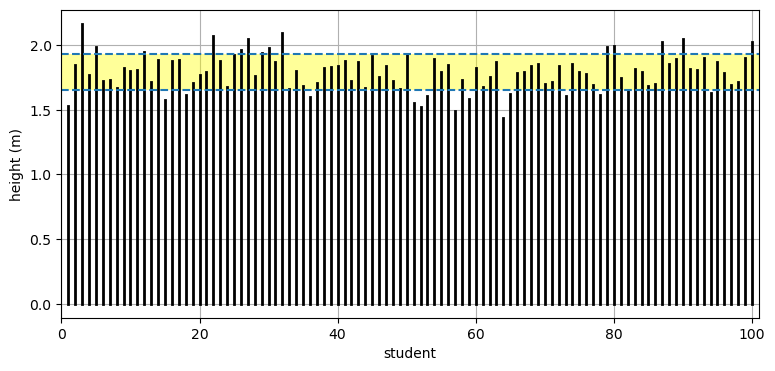

mean = 1.791
std  = 0.139


In [23]:
from numpy.random import randn
data = 1.8 + randn(100)*.1414
mean, std = data.mean(), data.std()

plot_height_std(data, lw=2)
print(f'mean = {mean:.3f}')
print(f'std  = {std:.3f}')

На глаз примерно 68% высот лежат в пределах $\pm1\sigma$ от среднего значения 1,8, но мы можем проверить это с помощью кода.

In [24]:
np.sum((data > mean-std) & (data < mean+std)) / len(data) * 100.

72.0

Скоро мы обсудим это более подробно. А пока давайте вычислим стандартное отклонение для

$$Y = [2.2, 1.5, 2.3, 1.7, 1.3]$$

Среднее значение $Y$ равно $\mu=1.8$ m, так что

$$ 
\begin{aligned}
\sigma_y &=\sqrt{\frac{(2.2-1.8)^2 + (1.5-1.8)^2 + (2.3-1.8)^2 + (1.7-1.8)^2 + (1.3-1.8)^2} {5}} \\
&= \sqrt{0.152} = 0.39 \ m
\end{aligned}$$

Мы проверим это с помощью NumPy

In [26]:
print(f'Стандартное отклоенение для Y это {np.std(Y):.2f} метров')

Стандартное отклоенение для Y это 0.39 метров


Это соответствует тому, что мы ожидали бы. Существует больше различий в высотах для $ Y$, и стандартное отклонение больше.

Наконец, давайте вычислим стандартное отклонение для $Z$. Отклонений в значениях нет, поэтому мы ожидаем, что стандартное отклонение будет равно нулю.
$$ 
\begin{aligned}
\sigma_z &=\sqrt{\frac{(1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2} {5}} \\
&= \sqrt{\frac{0+0+0+0+0}{5}} \\
\sigma_z&= 0.0 \ m
\end{aligned}$$

In [27]:
print(np.std(Z))

0.0


Прежде чем мы продолжим, я должен отметить, что я игнорирую тот факт, что в среднем мужчины выше женщин. В целом разница в росте в классе, состоящем только из мужчин или женщин, будет меньше, чем в классе с обоими полами. Это справедливо и для других факторов. Хорошо питающиеся дети выше ростом, чем дети, страдающие от недоедания. Скандинавы выше итальянцев. При разработке экспериментов статистики должны учитывать эти факторы. 

Я предположил, что мы могли бы провести этот анализ, чтобы заказать столы для школьного округа.  Для каждой возрастной группы, вероятно, будут два разных средних значения - одно сгруппировано вокруг среднего роста женщин, а второе среднее значение сгруппировано вокруг среднего роста мужчин. Среднее значение для всего класса будет где-то между этими двумя значениями. Если мы купим парты для среднего числа всех учеников, то, скорее всего, в итоге получим парты, которые не подходят ни для мужчин, ни для женщин в школе! 

Мы не будем рассматривать эти вопросы в этой книге.  Почитатйте литературу о вероятности, если вам нужно изучить методы решения этих проблем.

### Почему квадрат различий?

Почему мы принимаем *квадрат* различий за дисперсию? Я мог бы подробно заняться математикой, но давайте посмотрим на это простым способом. Вот диаграмма значений $X$, построенная по отношению к среднему значению для $X=[3,-3,3,-3]$

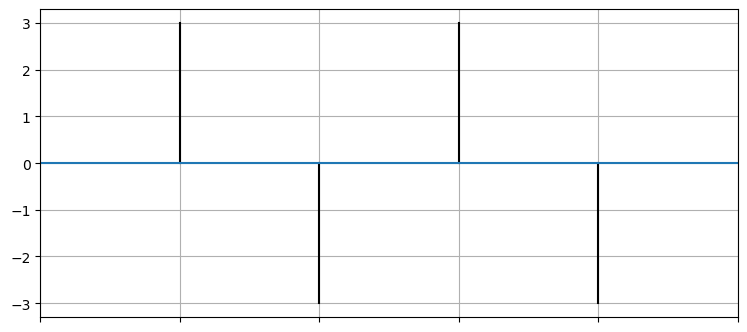

In [28]:
X = [3, -3, 3, -3]
mean = np.average(X)
for i in range(len(X)):
    plt.plot([i ,i], [mean, X[i]], color='k')
plt.axhline(mean)
plt.xlim(-1, len(X))
plt.tick_params(axis='x', labelbottom=False)

Если бы мы не взяли квадрат различий, знаки бы все перечеркнули:

$$\frac{(3-0) + (-3-0) + (3-0) + (-3-0)}{4} = 0$$

Это явно неверно, так как в данных имеется отклонение более 0. 

Может быть, мы можем использовать абсолютное значение? При осмотре мы можем видеть, что результат равен $ 12/4 = 3 $, что, безусловно, правильно — каждое значение отличается на 3 от среднего. Но что, если у нас есть $Y=[6, -2, -3, 1]$? В этом случае мы получаем $12/4=3$. $ Y$ явно более разбросан, чем $X$, но вычисление дает ту же дисперсию. Если мы используем формулу с использованием квадратов, мы получим дисперсию 3,5 для $Y$, что отражает ее большую вариацию.

Это не является доказательством правильности. Действительно, Карл Фридрих Гаусс, изобретатель этой техники, признал, что она несколько произвольна. Если есть выбросы, то возведение разницы в квадрат придает этому термину непропорциональный вес. Например, давайте посмотрим, что произойдет, если у нас есть:

In [31]:
X = [1, -1, 1, -2, -1, 2, 1, 2, -1, 1, -1, 2, 1, -2, 100]
print(f'Дисперсия X с выбросом    = {np.var(X):6.2f}')
print(f'Дисперсия X без выбросов  = {np.var(X[:-1]):6.2f}')

Дисперсия X с выбросом    = 621.45
Дисперсия X без выбросов  =   2.03


Является ли это "правильным"? Ты мне скажи. Без выброса 100 мы получаем $\sigma^2 = 2,03$, что точно отражает, как изменяется $X$ при отсутствии выброса. Один выброс заглушает вычисление дисперсии. Хотим ли мы затопить вычисления, чтобы мы знали, что есть выброс, или надежно включить выброс и по-прежнему предоставлять оценку, близкую к значению, отсутствующему в выбросах? Опять же, ты мне скажи. Очевидно, это зависит от вашей проблемы.

Я не буду продолжать идти по этому пути; если вам интересно, вы, возможно, захотите взглянуть на работу, проделанную Джеймсом Бергером по этой проблеме, в области, называемой "Байесовская надежность", или на отличные публикации по "надежной статистике" Питера Дж. Хубера [4]. В этой книге мы всегда будем использовать дисперсию и стандартное отклонение, определенные Гауссом.

Из этого следует сделать вывод, что эти *сводные* статистические данные всегда рассказывают неполную историю о наших данных. В этом примере дисперсия, определенная Гауссом, не говорит нам, что у нас есть один большой выброс. Тем не менее, это мощный инструмент, поскольку мы можем кратко описать большой набор данных с помощью нескольких чисел. Если бы у нас был 1 миллиард точек данных, мы бы не хотели просматривать графики на глаз или просматривать списки чисел; сводная статистика дает нам способ описать форму данных полезным способом.

## Гауссианы

Теперь мы готовы узнать о [гауссианах](https://en.wikipedia.org/wiki/Gaussian_function ). Давайте напомним себе о мотивации этой главы.

> Нам нужен унимодальный, непрерывный способ представления вероятностей, который моделирует, как работает реальный мир, и который эффективен с точки зрения вычислений.

Давайте посмотрим на график распределения Гаусса, чтобы получить представление о том, о чем мы говорим.

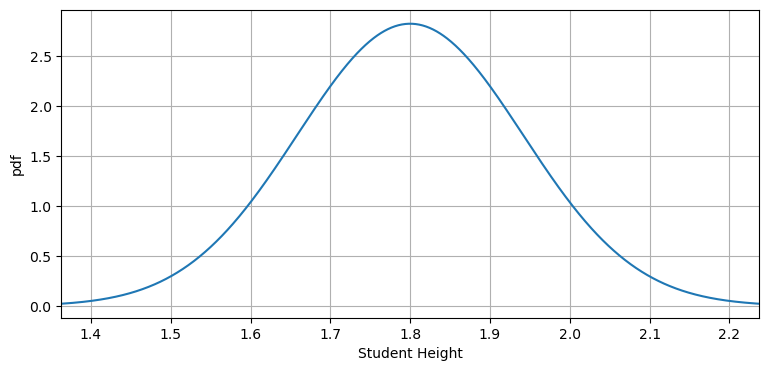

In [32]:
from filterpy.stats import plot_gaussian_pdf
plot_gaussian_pdf(mean=1.8, variance=0.1414**2, 
                  xlabel='Student Height', ylabel='pdf');

Эта кривая представляет собой [*функцию плотности вероятности*](https://en.wikipedia.org/wiki/Probability_density_function) или сокращенно *ФПВ*. Он показывает относительную вероятность того, что случайная величина примет определенное значение. Из диаграммы мы можем сказать, что у студента несколько больше шансов иметь рост около 1,8 м, чем 1,7 м, и гораздо больше шансов иметь рост 1,9 м против 1,4 м. Другими словами, у многих студентов рост будет около 1,8 м, и очень немногие студенты будут иметь рост около 1,4 м или 2,2 метра. Наконец, обратите внимание, что кривая центрирована по среднему значению 1,8 м.

> Я объясняю, как строить гауссианы и многое другое, в записной книжке *Computing_and_Plotting_PDFs* в 
Папка Supporting_Notebooks. Вы можете прочитать его онлайн [здесь](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb) [1].

Это может быть узнаваемо для вас как "колоколообразная кривая". Эта кривая повсеместна, потому что в реальных условиях многие наблюдения распределяются таким образом. Я не буду использовать термин "колоколообразная кривая" для обозначения гауссовой кривой, потому что многие распределения вероятностей имеют аналогичную форму колоколообразной кривой. Нематематические источники могут быть не столь точными, поэтому будьте благоразумны в своих выводах, когда увидите, что термин используется без определения.

Эта кривая не уникальна для высот — огромное количество природных явлений демонстрирует такое распределение, включая датчики, которые мы используем в задачах фильтрации. Как мы увидим, он также обладает всеми атрибутами, которые мы ищем — он представляет собой унимодальное убеждение или значение в виде вероятности, он непрерывен и эффективен с точки зрения вычислений. Вскоре мы обнаружим, что у него есть и другие желательные качества, о которых мы, возможно, не подозреваем, что желаем.

Чтобы еще больше мотивировать вас, вспомните формы распределений вероятностей в главе "Дискретный Байесовский фильтр":

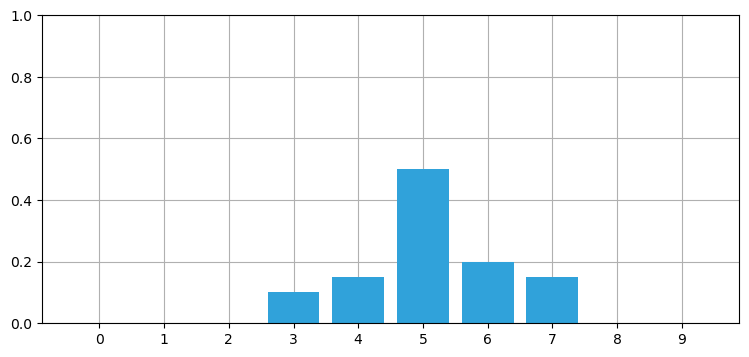

In [33]:
import kf_book.book_plots as book_plots
belief = [0., 0., 0., 0.1, 0.15, 0.5, 0.2, .15, 0, 0]
book_plots.bar_plot(belief)

Это были не идеальные гауссовы кривые, но они были похожи. Мы будем использовать гауссианы для замены дискретных вероятностей, используемых в этой главе!

## Номенклатура

Немного терминологии, прежде чем мы продолжим - на этой диаграмме показана *плотность вероятности случайной величины*, имеющей любое значение между ($-\infty..\infty)$. Что это значит? Представьте, что мы проводим бесконечное количество бесконечно точных измерений скорости автомобилей на участке шоссе. Затем мы могли бы построить график результатов, показав относительное количество автомобилей, проезжающих мимо с любой заданной скоростью. Если бы средняя скорость составляла 120 км/ ч, это могло бы выглядеть так:

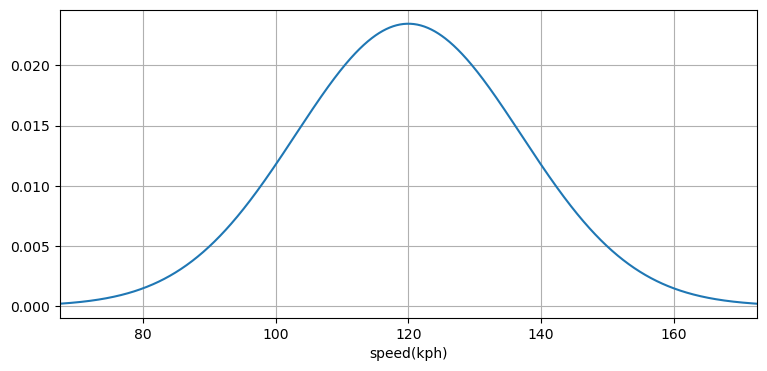

In [34]:
plot_gaussian_pdf(mean=120, variance=17**2, xlabel='speed(kph)');

Ось y показывает *плотность вероятности* — относительное количество автомобилей, которые развивают скорость на соответствующей оси x. Я объясню это подробнее в следующем разделе.

Гауссова модель несовершенна. Хотя эти диаграммы этого не показывают, "хвосты" распределения простираются до бесконечности. *Хвосты* - это дальние концы кривой, где значения являются самыми низкими. Конечно, высота человека или скорость автомобиля не могут быть меньше нуля, не говоря уже о $-\infty$ или $\infty$. “Карта - это не территория” - распространенное выражение, и оно справедливо для байесовской фильтрации и статистики. Приведенное выше распределение Гаусса моделирует распределение измеренных автомобильных скоростей, но, будучи моделью, оно обязательно несовершенно. Разница между моделью и реальностью будет всплывать снова и снова в этих фильтрах. Гауссианы используются во многих областях математики не потому, что они идеально моделируют реальность, а потому, что их проще использовать, чем любой другой относительно точный выбор. Однако даже в этой книге гауссианам не удастся смоделировать реальность, что вынудит нас использовать дорогостоящие в вычислительном отношении альтернативы. 

Вы услышите, что эти распределения называются *гауссовскими распределениями* или *нормальными распределениями*.  *Гауссовский* и *нормальный* оба означают одно и то же в этом контексте и используются взаимозаменяемо. Я буду использовать оба термина на протяжении всей этой книги, поскольку в разных источниках будут использоваться оба термина, и я хочу, чтобы вы привыкли видеть оба. Наконец, как и в этом параграфе, обычно сокращают название и говорят о *гауссовском* или *нормальном* — оба они являются типичными сокращенными именами для *распределения Гаусса*. 

## Гауссовы распределения

Давайте рассмотрим, как работают гауссианы. Гауссово - это *непрерывное распределение вероятностей*, которое полностью описывается двумя параметрами: средним значением ($\mu$) и дисперсией ($\sigma^2$). Он определяется как:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

$\exp[x]$ - это обозначение для $e^x$.

Не отговаривайтесь уравнением, если вы не видели его раньше; вам не нужно будет запоминать или манипулировать им. Вычисление этой функции хранится в `stats.py` с функцией `gaussian(x, mean, var, normed=True)`.
    
Лишенный констант, вы можете видеть, что это простая экспоненциальная:
    
$$f(x)\propto e^{-x^2}$$

который имеет знакомую форму колоколообразной кривой

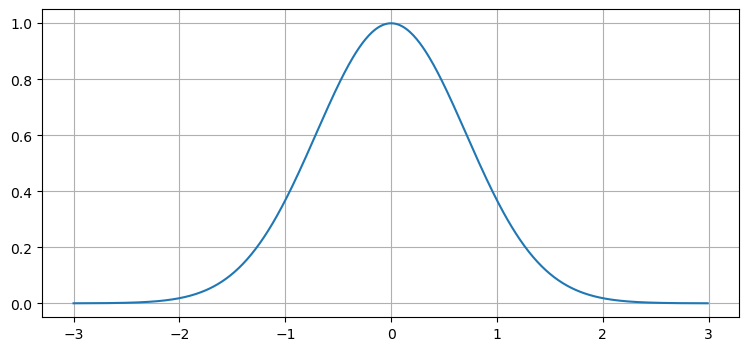

In [35]:
x = np.arange(-3, 3, .01)
plt.plot(x, np.exp(-x**2));

Давайте напомним себе, как смотреть на код функции. В ячейке введите название функции, за которым следуют два вопросительных знака, и нажмите CTRL+ENTER. Это откроет всплывающее окно с отображением источника. Раскомментируйте следующую ячейку и попробуйте сделать это сейчас.

In [36]:
from filterpy.stats import gaussian
#gaussian??

Давайте построим график Гаусса со средним значением 22 $(\mu = 22) $ с дисперсией 4 $ (\sigma^2=4)$. 

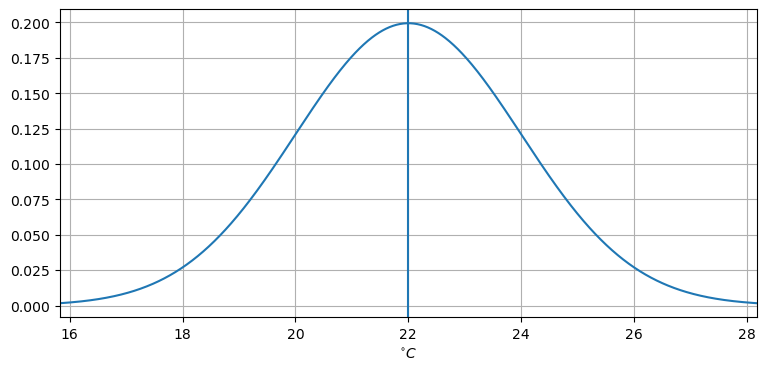

In [37]:
plot_gaussian_pdf(22, 4, mean_line=True, xlabel='$^{\circ}C$');

Что означает эта кривая *означает*? Предположим, у нас есть термометр, который показывает 22 °C. Ни один термометр не является абсолютно точным, и поэтому мы ожидаем, что каждое показание будет немного отличаться от фактического значения. Однако теорема, называемая [*Центральная предельная теорема*](https://en.wikipedia.org/wiki/Central_limit_theorem) утверждает, что если мы сделаем много измерений, то измерения будут нормально распределены. Когда мы смотрим на эту диаграмму, мы видим, что она пропорциональна вероятности того, что термометр покажет определенное значение, учитывая фактическую температуру 22 ° C.

Напомним, что гауссово распределение является *непрерывным*. Подумайте о бесконечно длинной прямой линии - какова вероятность того, что точка, которую вы выбираете случайным образом, равна 2. Очевидно, что 0%, поскольку существует бесконечное количество вариантов на выбор. То же самое верно и для нормальных распределений; на приведенном выше графике вероятность быть *ровно* 2° C равна 0%, потому что существует бесконечное число значений, которые могут принимать показания.

Что это за кривая? Это то, что мы называем *функцией плотности вероятности*. бласть под кривой в любой области дает вам вероятность этих значений. Так, например, если вы вычислите площадь под кривой между 20 и 22, результирующая площадь будет представлять собой вероятность того, что показания температуры находятся между этими двумя температурами. 

Вот еще один способ понять это. Какова *плотность* камня или губки? Это мера того, сколько массы уплотняется в данном пространстве. Скалы плотные, губки менее плотные. Итак, если вы хотели узнать, сколько весит камень, но у вас не было весов, вы могли бы взять его объем и умножить на его плотность. Это дало бы вам его массу. На практике плотность варьируется в большинстве объектов, поэтому вы должны интегрировать локальную плотность по объему породы.

$$M = \iiint_R p(x,y,z)\, dV$$

Мы делаем то же самое с *плотностью вероятности*. Если вы хотите знать температуру от 20 ° C до 21 ° C, вам следует интегрировать приведенную выше кривую от 20 до 21. Как вы знаете, интеграл кривой дает вам площадь под кривой. Поскольку это кривая плотности вероятности, интегралом от плотности является вероятность. 

Какова вероятность того, что температура будет ровно 22°C? Интуитивно понятно, что 0. Это действительные числа, и вероятность 22°Cvs, скажем, 22.00000000000017°C бесконечно мала. Математически, что бы мы получили, если бы интегрировали от 22 до 22? Ноль.

Возвращаясь к камню, каков вес одной точки на камне? Бесконечно малая точка не должна иметь веса. Нет смысла спрашивать вес одной точки, и нет смысла спрашивать о вероятности непрерывного распределения, имеющего одно значение. Ответ для обоих, очевидно, равен нулю.

На практике наши датчики не обладают бесконечной точностью, поэтому показания 22 ° C подразумевают диапазон, например 22 $\pm$ 0,1 ° C, и мы можем вычислить вероятность этого диапазона путем интегрирования от 21,9 до 22,1.

Мы можем думать об этом в байесовских терминах или частотных терминах. Как байесовский, если термометр показывает ровно 22 ° C, то наше убеждение описывается кривой - наше убеждение в том, что фактическая (системная) температура близка к 22 ° C, очень высокое, а наше убеждение в том, что фактическая температура близка к 18, очень низкое. Как специалист по частоте, мы бы сказали, что если бы мы провели 1 миллиард измерений температуры системы ровно при 22 ° C, то гистограмма измерений выглядела бы как эта кривая. 

Как вы вычисляете вероятность или площадь под кривой? Вы интегрируете уравнение для Гауссианы 

$$ \int^{x_1}_{x_0}  \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}{(x-\mu)^2}/\sigma^2 } dx$$

Это называется *кумулятивным распределением вероятностей*, обычно сокращенным *КДВ*.

Я написал `filterpy.stats.norm_cdf`, который вычисляет интеграл для вас. Например, мы можем вычислить

In [39]:
from filterpy.stats import norm_cdf
print('Совокупная вероятность в диапазоне от 21,5 до 22,5 составляет {:.2f}%'.format(
      norm_cdf((21.5, 22.5), 22,4)*100))
print('Совокупная вероятность в диапазоне от 23,5 до 24,5 составляет {:.2f}%'.format(
      norm_cdf((23.5, 24.5), 22,4)*100))

Совокупная вероятность в диапазоне от 21,5 до 22,5 составляет 19.74%
Совокупная вероятность в диапазоне от 23,5 до 24,5 составляет 12.10%


Среднее значение ($\mu$) — это то, на что оно похоже, - среднее значение всех возможных вероятностей. Из-за симметричной формы кривой это также самая высокая часть кривой. Термометр показывает 22 ° C, так что это то, что мы использовали для среднего значения.  

Обозначение нормального распределения для случайной величины $X$ равно $X \sim\ \mathcal{N}(\mu,\sigma^2)$, где $\sim$ означает *распределенное в соответствии с*. Это означает, что я могу выразить показания температуры нашего термометра как

$$\text{temp} \sim \mathcal{N}(22,4)$$

Это чрезвычайно важный результат. Гауссианы позволяют мне фиксировать бесконечное число возможных значений только с помощью двух чисел! Со значениями $ \mu = 22$ и $\sigma^2 = 4$ я могу вычислить распределение измерений в любом диапазоне.

Некоторые источники используют $\mathcal N (\mu, \sigma)$ вместо $\mathcal N (\mu, \sigma^2)$. И то, и другое прекрасно, они оба являются условностями. Вам нужно иметь в виду, какая форма используется, если вы видите такой термин, как $\mathcal {N}(22,4) $. В этой книге я всегда использую $\mathcal N (\mu, \sigma ^ 2)$, так что $\sigma =2$, $\sigma ^ 2 = 4$ для этого примера.

## The Variance and Belief

Поскольку это распределение плотности вероятности, требуется, чтобы площадь под кривой всегда была равна единице. Это должно быть интуитивно понятно — область под кривой представляет все возможные исходы, *что-то* произошло, а вероятность того, что * что-то произойдет*, равна единице, поэтому плотность должна быть равна единице. Мы можем доказать это сами с помощью небольшого кода. (Если вы склонны к математике, интегрируйте уравнение Гаусса из $-\infty$ в $\infty$)

In [40]:
print(norm_cdf((-1e8, 1e8), mu=0, var=4))

1.0


Это приводит к важному пониманию. Если отклонение невелико, кривая будет узкой. это связано с тем, что дисперсия является мерой того, *насколько* выборки отличаются от среднего значения. Чтобы сохранить площадь равной 1, кривая также должна быть высокой. С другой стороны, если дисперсия велика, кривая будет широкой, и, следовательно, она также должна быть короткой, чтобы площадь была равна 1.

Давайте посмотрим на это графически. Мы будем использовать вышеупомянутый `filterpy.stats.gaussian`, который может принимать либо одно значение, либо массив значений.

In [41]:
from filterpy.stats import gaussian

print(gaussian(x=3.0, mean=2.0, var=1))
print(gaussian(x=[3.0, 2.0], mean=2.0, var=1))

0.24197072451914337
[0.378 0.622]


По умолчанию `gaussian` нормализует выходные данные, что превращает выходные данные обратно в распределение вероятностей. Используйте аргумент `normed`, чтобы управлять этим.

In [42]:
print(gaussian(x=[3.0, 2.0], mean=2.0, var=1, normed=False))

[0.242 0.399]


Если гауссово распределение не нормализовано, оно называется *функцией Гаусса* вместо *распределения Гаусса*.

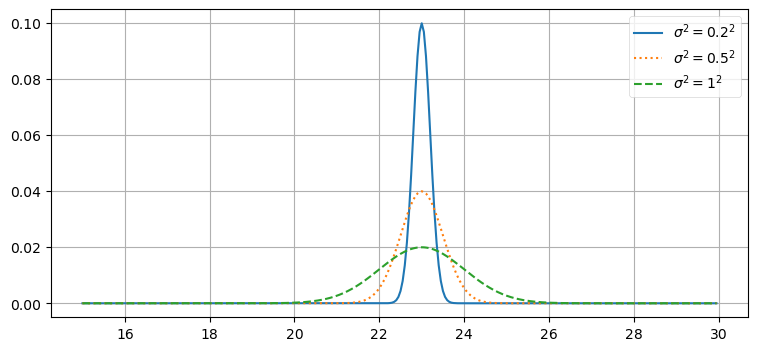

In [43]:
xs = np.arange(15, 30, 0.05)
plt.plot(xs, gaussian(xs, 23, 0.2**2), label='$\sigma^2=0.2^2$')
plt.plot(xs, gaussian(xs, 23, .5**2), label='$\sigma^2=0.5^2$', ls=':')
plt.plot(xs, gaussian(xs, 23, 1**2), label='$\sigma^2=1^2$', ls='--')
plt.legend();

О чем это нам говорит? Гауссов с $\sigma^2 = 0.2^2$ очень узок. Это говорит о том, что мы считаем, что $x = 23$, и что мы очень уверены в этом: в пределах $\pm 0.2$ std. Напротив, гауссиан с $\sigma^2 = 1^2$ также считает, что $x = 23$, но мы гораздо менее уверены в этом. Наше убеждение в том, что $x = 23$ ниже, и поэтому наше убеждение о вероятных возможных значениях для $x$ распространяется — мы думаем, что вполне вероятно, что $x = 20$ или $x = 26$, например. $\sigma^2 = 0.2^2$ почти полностью исключил $22$ или $24$ в качестве возможных значений, тогда как $\sigma^2 = 1 ^ 2$ считает их почти такими же вероятными, как $23$.

Если мы вспомним о термометре, мы можем рассматривать эти три кривые как представляющие показания трех разных термометров. Кривая для $\sigma^2 = 0,2^2$ представляет собой очень точный термометр, а кривая для $\sigma^2 = 1^2$ представляет собой довольно неточный. Обратите внимание на очень мощное свойство, которое дает нам распределение Гаусса — мы можем полностью представить как показания, так и погрешность термометра только с помощью двух чисел — среднего и дисперсии.

Эквивалентной формацией для гауссова является $\mathcal {N} (\mu,1/\tau) $, где $\mu $ - *среднее значение*, а $\tau $ - *точность*. $1/\tau = \sigma^2$; это обратная величина дисперсии. Хотя мы не используем эту формулировку в этой книге, она подчеркивает, что дисперсия является мерой точности наших данных. Небольшое отклонение дает большую точность — наши измерения очень точны. И наоборот, большая дисперсия приводит к низкой точности — наше убеждение распространяется на большую площадь. Вы должны привыкнуть думать о гауссианах в этих эквивалентных формах. В байесовских терминах гауссианы отражают наше *убеждение* в измерении, они выражают *точность* измерения и выражают, насколько велика *дисперсия* в измерениях. Все это разные способы констатации одного и того же факта.

Я забегаю вперед, но в следующих главах мы будем использовать гауссианы, чтобы выразить нашу веру в такие вещи, как предполагаемое положение объекта, который мы отслеживаем, или точность датчиков, которые мы используем.

## Правило 68-95-99.7

Сейчас стоит сказать несколько слов о стандартном отклонении. Стандартное отклонение - это показатель того, насколько данные отклоняются от среднего значения. Для гауссовских распределений 68% всех данных находятся в пределах одного стандартного отклонения ($\pm1\sigma$) от среднего значения, 95% находятся в пределах двух стандартных отклонений ($\pm2\sigma $) и 99,7% в пределах трех ($\pm3\sigma $). Это часто называют правилом [68-95-99.7](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). Если бы вам сказали, что средний балл теста в классе составил 71 при стандартном отклонении 9,4, вы могли бы сделать вывод, что 95% учащихся получили балл от 52,2 до 89,8, если распределение нормальное (то есть рассчитывается с помощью $71 \pm (2 * 9,4) $). 

Наконец, это не произвольные числа. Если гауссово значение для нашей позиции равно $\mu=22$ метров, то стандартное отклонение также имеет единицы измерения. Таким образом, $\sigma=0.2$ означает, что 68% измерений находятся в диапазоне от 21,8 до 22,2 метров. Дисперсия - это стандартное отклонение в квадрате, таким образом, $\sigma ^ 2 = .04$ метров $^2$. Как вы видели в предыдущем разделе, запись $\sigma 2 = 0.2^2$ может сделать это несколько более значимым, поскольку 0.2 находится в тех же единицах измерения, что и данные.

На следующем графике показана взаимосвязь между стандартным отклонением и нормальным распределением.

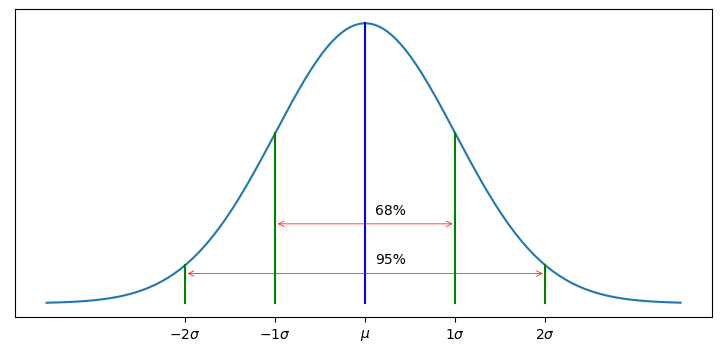

In [44]:
from kf_book.gaussian_internal import display_stddev_plot
display_stddev_plot()

## Интерактивные гауссианы

Для тех, кто читает это в записной книжке Jupyter, вот интерактивная версия гауссовых графиков. Используйте ползунки для изменения $\mu$ и $\sigma^2$. Настройка $\mu $ переместит график влево и вправо, потому что вы корректируете среднее значение, а настройка $\sigma^2$ сделает колоколообразную кривую толще и тоньше.

In [45]:
import math
from ipywidgets import interact, FloatSlider

def plt_g(mu,variance):
    plt.figure()
    xs = np.arange(2, 8, 0.01)
    ys = gaussian(xs, mu, variance)
    plt.plot(xs, ys)
    plt.ylim(0, 0.04)

interact(plt_g, mu=FloatSlider(value=5, min=3, max=7),
         variance=FloatSlider(value = .03, min=.01, max=1.));

interactive(children=(FloatSlider(value=5.0, description='mu', max=7.0, min=3.0), FloatSlider(value=0.03, desc…

Наконец, если вы читаете это онлайн, вот анимация гауссова. Во-первых, среднее значение смещается вправо. Затем среднее значение центрируется на уровне $\mu = 5$ и изменяется дисперсия.

<img src='animations/04_gaussian_animate.gif'>

## Computational Properties of Gaussians

The discrete Bayes filter works by multiplying and adding arbitrary probability distributions. The Kalman filter uses Gaussians instead of arbitrary distributions, but the rest of the algorithm remains the same. This means we will need to multiply and add Gaussians. 

A remarkable property of Gaussians is that the sum of two independent independent normal variables (https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables) is also normally distributed! The product is not Gaussian, but proportional to a Gaussian. There we can say that the result of multipying two Gaussian distributions is a Gaussian function (recall function in this context means that the property that the values sum to one is not guaranteed).

Before we do the math, let's test this visually. 

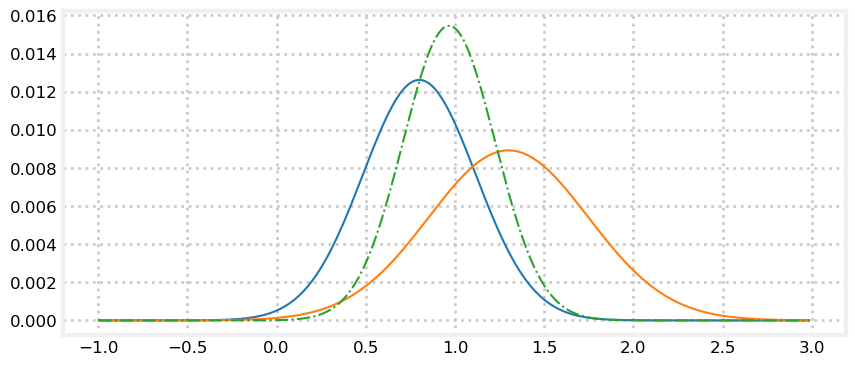

In [32]:
x = np.arange(-1, 3, 0.01)
g1 = gaussian(x, mean=0.8, var=.1)
g2 = gaussian(x, mean=1.3, var=.2)
plt.plot(x, g1, x, g2)

g = g1 * g2  # element-wise multiplication
g = g / sum(g)  # normalize
plt.plot(x, g, ls='-.');

Here I created two Gaussians, g1=$\mathcal N(0.8, 0.1)$ and g2=$\mathcal N(1.3, 0.2)$ and plotted them. Then I multiplied them together and normalized the result. As you can see the result *looks* like a Gaussian distribution.

Gaussians are nonlinear functions. Typically, if you multiply a nonlinear equations you end up with a different type of function. For example, the shape of multiplying two sins is very different from `sin(x)`.

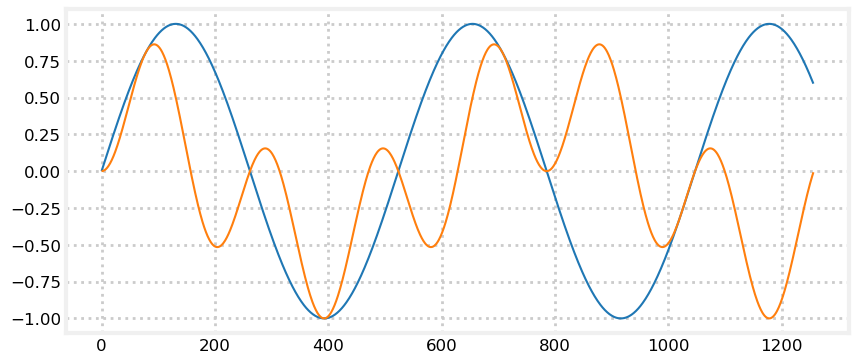

In [33]:
x = np.arange(0, 4*np.pi, 0.01)
plt.plot(np.sin(1.2*x))
plt.plot(np.sin(1.2*x) * np.sin(2*x));

But the result of multiplying two Gaussians distributions is a Gaussian function. This is a key reason why Kalman filters are computationally feasible. Said another way, Kalman filters use Gaussians *because* they are computationally nice. 

The product of two independent Gaussians is given by:

$$\begin{aligned}\mu &=\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}\\
\sigma^2 &=\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} 
\end{aligned}$$

The sum of two Gaussians is given by

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

At the end of the chapter I derive these equations. However, understanding the deriviation is not very important.

## Putting it all Together

Now we are ready to talk about how Gaussians can be used in filtering. In the next chapter we will implement a filter using Gaussins. Here I will explain why we would want to use Gaussians.

In the previous chapter we represented probability distributions with an array. We performed the update computation by computing the element-wise product of that distribution with another distribution representing the likelihood of the measurement at each point, like so:

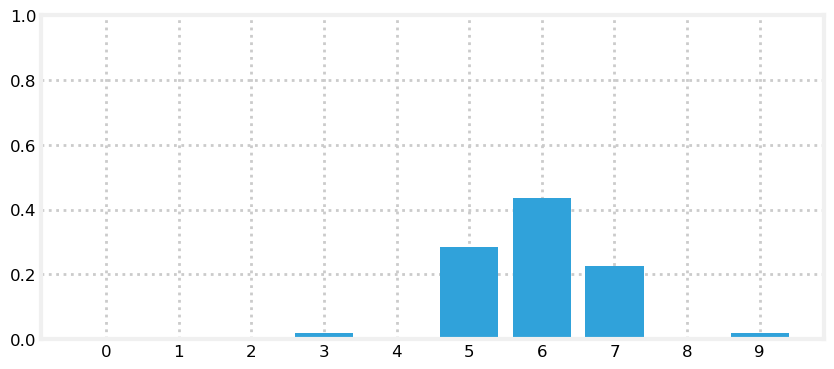

In [34]:
def normalize(p):
    return p / sum(p)

def update(likelihood, prior):
    return normalize(likelihood * prior)

prior =      normalize(np.array([4, 2, 0, 7, 2, 12, 35, 20, 3, 2]))
likelihood = normalize(np.array([3, 4, 1, 4, 2, 38, 20, 18, 1, 16]))
posterior = update(likelihood, prior)
book_plots.bar_plot(posterior)

In other words, we have to compute 10 multiplications to get this result. For a real filter with large arrays in multiple dimensions we'd require billions of multiplications, and vast amounts of memory. 

But this distribution looks like a Gaussian. What if we use a Gaussian instead of an array? I'll compute the mean and variance of the posterior and plot it against the bar chart.

mean: 5.88 var: 1.24


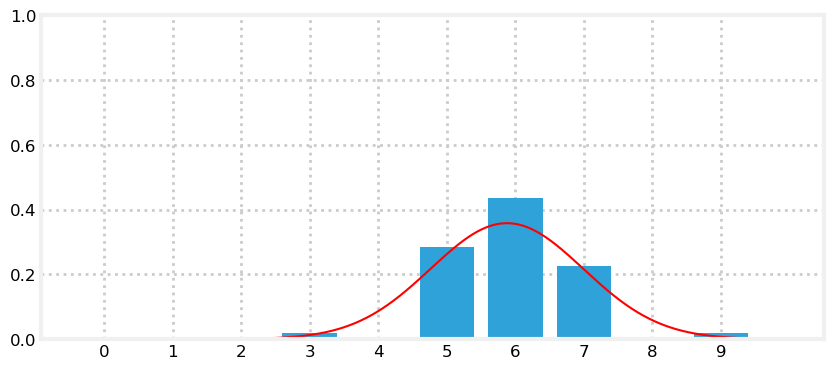

In [35]:
xs = np.arange(0, 10, .01)

def mean_var(p):
    x = np.arange(len(p))
    mean = np.sum(p * x,dtype=float)
    var = np.sum((x - mean)**2 * p)
    return mean, var

mean, var = mean_var(posterior)
book_plots.bar_plot(posterior)
plt.plot(xs, gaussian(xs, mean, var, normed=False), c='r');
print('mean: %.2f' % mean, 'var: %.2f' % var)

This is impressive. We can describe an entire distribution of numbers with only two numbers. Perhaps this example is not persuasive, given there are only 10 numbers in the distribution. But a real problem could have millions of numbers, yet still only require two numbers to describe it.

Next, recall that our filter implements the update function with
```python
def update(likelihood, prior):
    return normalize(likelihood * prior)
```

If the arrays contain a million elements, that is one million multiplications. However, if we replace the arrays with a Gaussian then we would perform that calculation with

$$\begin{aligned}\mu &=\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}\\
\sigma^2 &=\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} 
\end{aligned}$$

which is three multiplications and two divisions.

### Bayes Theorem

In the last chapter we developed an algorithm by reasoning about the information we have at each moment, which we expressed as discrete probability distributions. In the process we discovered [*Bayes' Theorem*](https://en.wikipedia.org/wiki/Bayes%27_theorem). Bayes theorem tells us how to compute the probability of an event given prior information. 

We implemented the `update()` function with this probability calculation:

$$ \mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{normalization}}$$ 

It turns out that this is Bayes' theorem. In a second I will develop the mathematics, but in many ways that obscures the simple idea expressed in this equation. We read this as:

$$ updated\,knowledge = \big\|likelihood\,of\,new\,knowledge\times prior\, knowledge \big\|$$

where $\| \cdot\|$ expresses normalizing the term.

We came to this with simple reasoning about a dog walking down a hallway. Yet, as we will see, the same equation applies to a universe of filtering problems. We will use this equation in every subsequent chapter.


To review, the *prior* is the probability of something happening before we include the probability of the measurement (the *likelihood*) and the *posterior* is the probability we compute after incorporating the information from the measurement.

Bayes theorem is

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$$

$P(A \mid B)$ is called a [*conditional probability*](https://en.wikipedia.org/wiki/Conditional_probability). That is, it represents the probability of $A$ happening *if* $B$ happened. For example, it is more likely to rain today compared to a typical day if it also rained yesterday because rain systems usually last more than one day. We'd write the probability of it raining today given that it rained yesterday as $P$(rain today $\mid$ rain yesterday).


I've glossed over an important point. In our code above we are not working with single probabilities, but an array of probabilities - a *probability distribution*. The equation I just gave for Bayes uses probabilities, not probability distributions. However, it is equally valid with probability distributions. We use a lower case $p$ for probability distributions

$$p(A \mid B) = \frac{p(B \mid A)\, p(A)}{p(B)}$$

In the equation above $B$ is the *evidence*, $p(A)$ is the *prior*, $p(B \mid A)$ is the *likelihood*, and $p(A \mid B)$ is the *posterior*. By substituting the mathematical terms with the corresponding words you can see that Bayes theorem matches our update equation. Let's rewrite the equation in terms of our problem. We will use $x_i$ for the position at *i*, and $z$ for the measurement. Hence, we want to know $P(x_i \mid z)$, that is, the probability of the dog being at $x_i$ given the measurement $z$. 

So, let's plug that into the equation and solve it.

$$p(x_i \mid z) = \frac{p(z \mid x_i) p(x_i)}{p(z)}$$

That looks ugly, but it is actually quite simple. Let's figure out what each term on the right means. First is $p(z \mid x_i)$. This is the likelihood, or the probability for the measurement at every cell $x_i$. $p(x_i)$ is the *prior* - our belief before incorporating the measurements. We multiply those together. This is just the unnormalized multiplication in the `update()` function:

```python
def update(likelihood, prior):
    posterior = prior * likelihood   # p(z|x) * p(x)
    return normalize(posterior)
```

The last term to consider is the denominator $p(z)$. This is the probability of getting the measurement $z$ without taking the location into account. It is often called the *evidence*. We compute that by taking the sum of $x$, or `sum(belief)` in the code. That is how we compute the normalization! So, the `update()` function is doing nothing more than computing Bayes' theorem.

The literature often gives you these equations in the form of integrals. After all, an integral is just a sum over a continuous function. So, you might see Bayes' theorem written as

$$p(A \mid B) = \frac{p(B \mid A)\, p(A)}{\int p(B \mid A_j) p(A_j) \,\, \mathtt{d}A_j}\cdot$$

This denominator is usually impossible to solve analytically; when it can be solved the math is fiendishly difficult. A recent [opinion piece ](http://www.statslife.org.uk/opinion/2405-we-need-to-rethink-how-we-teach-statistics-from-the-ground-up)for the Royal Statistical Society called it a "dog's breakfast" [8].  Filtering textbooks that take a Bayesian approach are filled with integral laden equations with no analytic solution. Do not be cowed by these equations, as we trivially handled this integral by normalizing our posterior. We will learn more techniques to handle this in the **Particle Filters** chapter. Until then, recognize that in practice it is just a normalization term over which we can sum. What I'm trying to say is that when you are faced with a page of integrals, just think of them as sums, and relate them back to this chapter, and often the difficulties will fade. Ask yourself "why are we summing these values", and "why am I dividing by this term". Surprisingly often the answer is readily apparent. Surprisingly often the author neglects to mention this interpretation.

It's probable that the strength of Bayes' theorem is not yet fully apparent to you. We want to compute $p(x_i \mid Z)$. That is, at step i, what is our probable state given a measurement. That's an extraordinarily difficult problem in general. Bayes' Theorem is general. We may want to know the probability that we have cancer given the results of a cancer test, or the probability of rain given various sensor readings. Stated like that the problems seem unsolvable.

But Bayes' Theorem lets us compute this by using the inverse  $p(Z\mid x_i)$, which is often straightforward to compute

$$p(x_i \mid Z) \propto p(Z\mid x_i)\, p(x_i)$$

That is, to compute how likely it is to rain given specific sensor readings we only have to compute the likelihood of the sensor readings given that it is raining! That's a ***much*** easier problem! Well, weather prediction is still a difficult problem, but Bayes makes it tractable. 

Likewise, as you saw in the Discrete Bayes chapter, we computed the likelihood that Simon was in any given part of the hallway by computing how likely a sensor reading is given that Simon is at position `x`. A hard problem becomes easy. 

### Total Probability Theorem

We now know the formal mathematics behind the `update()` function; what about the `predict()` function? `predict()` implements the [*total probability theorem*](https://en.wikipedia.org/wiki/Law_of_total_probability). Let's recall what `predict()` computed. It computed the probability of being at any given position given the probability of all the possible movement events. Let's express that as an equation. The probability of being at any position $i$ at time $t$ can be written as $P(X_i^t)$. We computed that as the sum of the prior at time $t-1$ $P(X_j^{t-1})$ multiplied by the probability of moving from cell $x_j$ to $x_i$. That is

$$P(X_i^t) = \sum_j P(X_j^{t-1})  P(x_i | x_j)$$

That equation is called the *total probability theorem*. Quoting from Wikipedia [6] "It expresses the total probability of an outcome which can be realized via several distinct events". I could have given you that equation and implemented `predict()`, but your chances of understanding why the equation works would be slim. As a reminder, here is the code that computes this equation

```python
for i in range(N):
    for k in range (kN):
        index = (i + (width-k) - offset) % N
        result[i] += prob_dist[index] * kernel[k]
```

## Computing Probabilities with scipy.stats

In this chapter I used code from [FilterPy](https://github.com/rlabbe/filterpy) to compute and plot Gaussians. I did that to give you a chance to look at the code and see how these functions are implemented.  However, Python comes with "batteries included" as the saying goes, and it comes with a wide range of statistics functions in the module `scipy.stats`. So let's walk through how to use scipy.stats to compute statistics and probabilities.

The `scipy.stats` module contains a number of objects which you can use to compute attributes of various probability distributions. The full documentation for this module is here: http://docs.scipy.org/doc/scipy/reference/stats.html. We will focus on the  norm variable, which implements the normal distribution. Let's look at some code that uses `scipy.stats.norm` to compute a Gaussian, and compare its value to the value returned by the `gaussian()` function from FilterPy.

In [36]:
from scipy.stats import norm
import filterpy.stats
print(norm(2, 3).pdf(1.5))
print(filterpy.stats.gaussian(x=1.5, mean=2, var=3*3))

0.13114657203397997
0.13114657203397995


The call `norm(2, 3)` creates what scipy calls a 'frozen' distribution - it creates and returns an object with a mean of 2 and a standard deviation of 3. You can then use this object multiple times to get the probability density of various values, like so:

In [37]:
n23 = norm(2, 3)
print('pdf of 1.5 is       %.4f' % n23.pdf(1.5))
print('pdf of 2.5 is also  %.4f' % n23.pdf(2.5))
print('pdf of 2 is         %.4f' % n23.pdf(2))

pdf of 1.5 is       0.1311
pdf of 2.5 is also  0.1311
pdf of 2 is         0.1330


The documentation for  [scipy.stats.norm](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.normfor) [2] lists many other functions. For example, we can generate $n$ samples from the distribution with the `rvs()` function.

In [38]:
np.set_printoptions(precision=3, linewidth=50)
print(n23.rvs(size=15))

[ 3.026  7.51  -2.588  6.081 -3.413 -1.11   6.484
  5.935  2.313  1.912  1.895  7.964  4.876 -0.841
 -0.174]


We can get the [*cumulative distribution function (CDF)*](https://en.wikipedia.org/wiki/Cumulative_distribution_function), which is the probability that a randomly drawn value from the distribution is less than or equal to $x$.

In [39]:
# probability that a random value is less than the mean 2
print(n23.cdf(2))

0.5


We can get various properties of the distribution:

In [40]:
print('variance is', n23.var())
print('standard deviation is', n23.std())
print('mean is', n23.mean())

variance is 9.0
standard deviation is 3.0
mean is 2.0


## Limitations of Using Gaussians to Model the World

Earlier I mentioned the *central limit theorem*, which states that under certain conditions the arithmetic sum of any independent random variable will be normally distributed, regardless of how the random variables are distributed. This is important to us because nature is full of distributions which are not normal, but when we apply the central limit theorem over large populations we end up with normal distributions. 

However, a key part of the proof is “under certain conditions”. These conditions often do not hold for the physical world. For example, a kitchen scale cannot read below zero, but if we represent the measurement error as a Gaussian the left side of the curve extends to negative infinity, implying a very small chance of giving a negative reading. 

This is a broad topic which I will not treat exhaustively. 

Let's consider a trivial example. We think of things like test scores as being normally distributed. If you have ever had a professor “grade on a curve” you have been subject to this assumption. But of course test scores cannot follow a normal distribution. This is because the distribution assigns a nonzero probability distribution for *any* value, no matter how far from the mean. So, for example, say your mean is 90 and the standard deviation is 13. The normal distribution assumes that there is a large chance of somebody getting a 90, and a small chance of somebody getting a 40. However, it also implies that there is a tiny chance of somebody getting a grade of -10, or 150. It assigns an extremely small chance of getting a score of $-10^{300}$ or $10^{32986}$. The tails of a Gaussian distribution are infinitely long.

But for a test we know this is not true. Ignoring extra credit, you cannot get less than 0, or more than 100. Let's plot this range of values using a normal distribution to see how poorly this represents real test scores distributions.

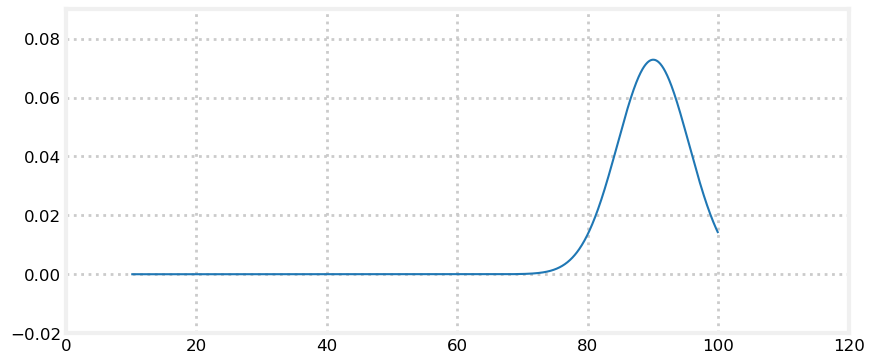

In [41]:
xs = np.arange(10, 100, 0.05)
ys = [gaussian(x, 90, 30) for x in xs]
plt.plot(xs, ys, label='var=0.2')
plt.xlim(0, 120)
plt.ylim(-0.02, 0.09);

The area under the curve cannot equal 1, so it is not a probability distribution. What actually happens is that more students than predicted by a normal distribution get scores nearer the upper end of the range (for example), and that tail becomes “fat”. Also, the test is probably not able to perfectly distinguish minute differences in skill in the students, so the distribution to the left of the mean is also probably a bit bunched up in places. 

Sensors measure the world. The errors in a sensor's measurements are rarely truly Gaussian. It is far too early to be talking about the difficulties that this presents to the Kalman filter designer. It is worth keeping in the back of your mind the fact that the Kalman filter math is based on an idealized model of the world.  For now I will present a bit of code that I will be using later in the book to form distributions to simulate various processes and sensors. This distribution is called the [*Student's $t$-distribution*](https://en.wikipedia.org/wiki/Student%27s_t-distribution). 

Let's say I want to model a sensor that has some white noise in the output. For simplicity, let's say the signal is a constant 10, and the standard deviation of the noise is 2. We can use the function `numpy.random.randn()` to get a random number with a mean of 0 and a standard deviation of 1. I can simulate this with:

In [42]:
from numpy.random import randn
def sense():
    return 10 + randn()*2

Let's plot that signal and see what it looks like.

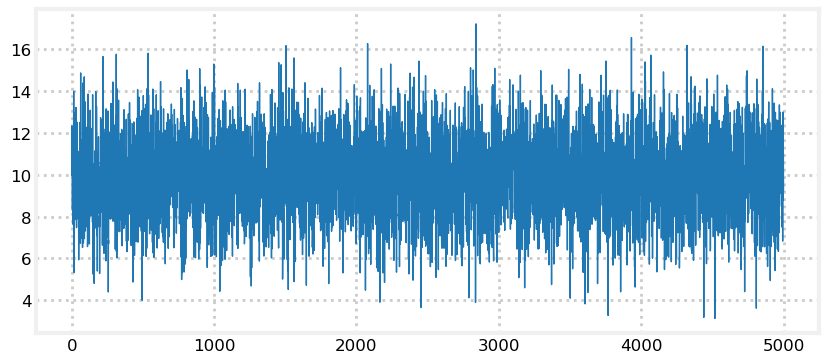

In [43]:
zs = [sense() for i in range(5000)]
plt.plot(zs, lw=1);

That looks like what I would expect. The signal is centered around 10. A standard deviation of 2 means that 68% of the measurements will be within $\pm$ 2 of 10, and 99% will be within $\pm$ 6 of 10, and that looks like what is happening. 

Now let's look at distribution generated with the Student's $t$-distribution. I will not go into the math, but just give you the source code for it and then plot a distribution using it.

In [44]:
import random
import math

def rand_student_t(df, mu=0, std=1):
    """return random number distributed by Student's t 
    distribution with `df` degrees of freedom with the 
    specified mean and standard deviation.
    """
    x = random.gauss(0, std)
    y = 2.0*random.gammavariate(0.5*df, 2.0)
    return x / (math.sqrt(y / df)) + mu

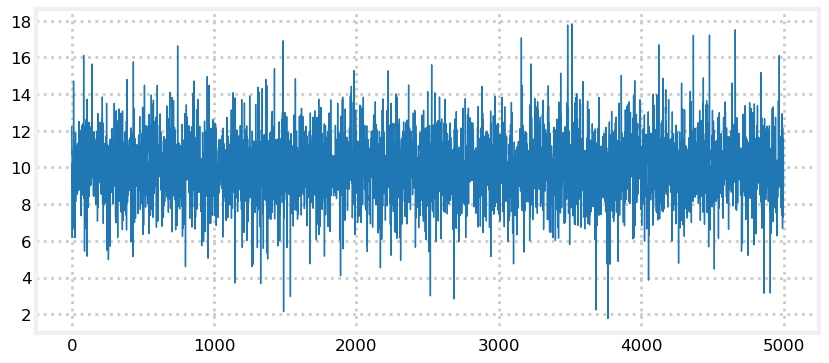

In [45]:
def sense_t():
    return 10 + rand_student_t(7)*2

zs = [sense_t() for i in range(5000)]
plt.plot(zs, lw=1);

We can see from the plot that while the output is similar to the normal distribution there are outliers that go far more than 3 standard deviations from the mean (7 to 13). 

It is unlikely that the Student's $t$-distribution is an accurate model of how your sensor (say, a GPS or Doppler) performs, and this is not a book on how to model physical systems. However, it does produce reasonable data to test your filter's performance when presented with real world noise. We will be using distributions like these throughout the rest of the book in our simulations and tests. 

This is not an idle concern. The Kalman filter equations assume the noise is normally distributed, and perform sub-optimally if this is not true. Designers for mission critical filters, such as the filters on spacecraft, need to master a lot of theory and empirical knowledge about the performance of the sensors on their spacecraft. For example, a presentation I saw on a NASA mission stated that while theory states that they should use 3 standard deviations to distinguish noise from valid measurements in practice they had to use 5 to 6 standard deviations. This was something they determined by experiments.

The code for rand_student_t is included in `filterpy.stats`. You may use it with

```python
from filterpy.stats import rand_student_t
```

While I'll not cover it here, statistics has defined ways of describing the shape of a probability distribution by how it varies from an exponential distribution. The normal distribution is shaped symmetrically around the mean - like a bell curve. However, a probability distribution can be asymmetrical around the mean. The measure of this is called [*skew*](https://en.wikipedia.org/wiki/Skewness). The tails can be shortened, fatter, thinner, or otherwise shaped differently from an exponential distribution. The measure of this is called [*kurtosis*](https://en.wikipedia.org/wiki/Kurtosis). the `scipy.stats` module contains the function `describe` which computes these statistics, among others.

In [46]:
import scipy
scipy.stats.describe(zs)

DescribeResult(nobs=5000, minmax=(1.7707248080804092, 17.824961707265643), mean=10.004201301507253, variance=2.721973140216924, skewness=-0.03534037712630867, kurtosis=1.583968849611276)

Let's examine two normal populations, one small, one large:

In [47]:
print(scipy.stats.describe(np.random.randn(10)))
print()
print(scipy.stats.describe(np.random.randn(300000)))

DescribeResult(nobs=10, minmax=(-1.1170056026895896, 1.0389413316321683), mean=-0.14317693801053674, variance=0.63137454114842, skewness=0.23966670696111078, kurtosis=-1.3702119526058378)

DescribeResult(nobs=300000, minmax=(-4.262303362805642, 4.603650808299195), mean=-0.00040808441709135014, variance=0.998953112076118, skewness=-0.0010979017079029859, kurtosis=-0.00030025117171517124)


The small sample has very non-zero skew and kurtosis because the small number of samples is not well distributed around the mean of 0. You can see this also by comparing the computed mean and variance with the theoretical mean of 0 and variance 1. In comparison the large sample's mean and variance are very close to the theoretical values, and both the skew and kurtosis are near zero.

## Product of Gaussians (Optional)

It is not important to read this section. Here I derive the equations for the product of two Gaussians.

You can find this result by multiplying the equation for two Gaussians together and combining terms. The algebra gets messy. I will derive it using Bayes theorem. We can state the problem as: let the prior be $N(\bar\mu, \bar\sigma^2)$, and measurement be $z \propto N(z, \sigma_z^2)$. What is the posterior  x given the measurement z?

Write the posterior as $p(x \mid z)$. Now we can use Bayes Theorem to state

$$p(x \mid z) = \frac{p(z \mid x)p(x)}{p(z)}$$

$p(z)$ is a normalizing constant, so we can create a proportinality

$$p(x \mid z) \propto p(z|x)p(x)$$

Now we subtitute in the equations for the Gaussians, which are

$$p(z \mid x) = \frac{1}{\sqrt{2\pi\sigma_z^2}}\exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]$$

$$p(x) = \frac{1}{\sqrt{2\pi\bar\sigma^2}}\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]$$

We can drop the leading terms, as they are constants, giving us

$$\begin{aligned}
p(x \mid z) &\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]\\
&\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z-x)^2+\sigma_z^2(x-\bar\mu)^2]\Big]
\end{aligned}$$

Now we multiply out the squared terms and group in terms of the posterior $x$.

$$\begin{aligned}
p(x \mid z) &\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z^2 -2xz + x^2) + \sigma_z^2(x^2 - 2x\bar\mu+\bar\mu^2)]\Big ] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z) + (\bar\sigma^2z^2+\sigma_z^2\bar\mu^2)]\Big ]
\end{aligned}$$

The last parentheses do not contain the posterior $x$, so it can be treated as a constant and discarded.

$$p(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z)}{\sigma_z^2\bar\sigma^2}\Big ]
$$

Divide numerator and denominator by $\bar\sigma^2+\sigma_z^2$ to get

$$p(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2-2x(\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

Proportionality allows us create or delete constants at will, so we can factor this into

$$p(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{(x-\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})^2}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

A Gaussian is

$$N(\mu,\, \sigma^2) \propto \exp\Big [-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2}\Big ]$$

So we can see that $p(x \mid z)$ has a mean of

$$\mu_\mathtt{posterior} = \frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2}$$

and a variance of
$$
\sigma_\mathtt{posterior} = \frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}
$$

I've dropped the constants, and so the result is not a normal, but proportional to one. Bayes theorem normalizes with the $p(z)$ divisor, ensuring that the result is normal. We normalize in the update step of our filters, ensuring the filter estimate is Gaussian.

$$\mathcal N_1 = \| \mathcal N_2\cdot \mathcal N_3\|$$

## Sum of Gaussians (Optional)

Likewise, this section is not important to read. Here I derive the equations for the sum of two Gaussians.

The sum of two Gaussians is given by

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

There are several proofs for this. I will use convolution since we used convolution in the previous chapter for the histograms of probabilities. 

To find the density function of the sum of two Gaussian random variables we sum the density functions of each. They are nonlinear, continuous functions, so we need to compute the sum with an integral. If the random variables $p$ and $z$ (e.g. prior and measurement) are independent we can compute this with

$p(x) = \int\limits_{-\infty}^\infty f_p(x-z)f_z(z)\, dx$

This is the equation for a convolution. Now we just do some math:


$p(x) = \int\limits_{-\infty}^\infty f_2(x-x_1)f_1(x_1)\, dx$

$=  \int\limits_{-\infty}^\infty 
\frac{1}{\sqrt{2\pi}\sigma_z}\exp\left[-\frac{(x - z - \mu_z)^2}{2\sigma^2_z}\right]
\frac{1}{\sqrt{2\pi}\sigma_p}\exp\left[-\frac{(x - \mu_p)^2}{2\sigma^2_p}\right] \, dx$

$=  \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

$= \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right] \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

The expression inside the integral is a normal distribution. The sum of a normal distribution is one, hence the integral is one. This gives us

$$p(x) = \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]$$

This is in the form of a normal, where

$$\begin{gathered}\mu_x = \mu_p + \mu_z \\
\sigma_x^2 = \sigma_z^2+\sigma_p^2\, \square\end{gathered}$$

## Summary and Key Points

This chapter is a poor introduction to statistics in general. I've only covered the concepts that  needed to use Gaussians in the remainder of the book, no more. What I've covered will not get you very far if you intend to read the Kalman filter literature. If this is a new topic to you I suggest reading a statistics textbook. I've always liked the Schaum series for self study, and Alan Downey's *Think Stats* [5] is also very good and freely available online. 

The following points **must** be understood by you before we continue:

* Normals express a continuous probability distribution
* They are completely described by two parameters: the mean ($\mu$) and variance ($\sigma^2$)
* $\mu$ is the average of all possible values
* The variance $\sigma^2$ represents how much our measurements vary from the mean
* The standard deviation ($\sigma$) is the square root of the variance ($\sigma^2$)
* Many things in nature approximate a normal distribution, but the math is not perfect.
* In filtering problems computing $p(x\mid z)$ is nearly impossible, but computing $p(z\mid x)$ is straightforward. Bayes' lets us compute the former from the latter. 

The next several chapters will be using Gaussians with Bayes' theorem to help perform filtering. As noted in the last section, sometimes Gaussians do not describe the world very well. Latter parts of the book are dedicated to filters which work even when the noise or system's behavior is very non-Gaussian. 

## References

[1] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb

[2] http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

[3] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

[4] Huber, Peter J. *Robust Statistical Procedures*, Second Edition. Society for Industrial and Applied Mathematics, 1996.

[5] Downey, Alan. *Think Stats*, Second Edition. O'Reilly Media.

https://github.com/AllenDowney/ThinkStats2

http://greenteapress.com/thinkstats/

## Useful Wikipedia Links

https://en.wikipedia.org/wiki/Probability_distribution

https://en.wikipedia.org/wiki/Random_variable

https://en.wikipedia.org/wiki/Sample_space

https://en.wikipedia.org/wiki/Central_tendency

https://en.wikipedia.org/wiki/Expected_value

https://en.wikipedia.org/wiki/Standard_deviation

https://en.wikipedia.org/wiki/Variance

https://en.wikipedia.org/wiki/Probability_density_function

https://en.wikipedia.org/wiki/Central_limit_theorem

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

https://en.wikipedia.org/wiki/Cumulative_distribution_function

https://en.wikipedia.org/wiki/Skewness

https://en.wikipedia.org/wiki/Kurtosis